# Transfer Learning on Tensorflow

This is example from official tensorflow docs

In [1]:
# This is to supress all CUDA warnings to make the output cleaner
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
# Importing the libraries

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [3]:
print(matplotlib.__version__)
print(tf.__version__)
print(np.__version__)

3.5.2
2.9.0
1.23.2


We use tensorflow utils to download and extract the dataset

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip' 
path_to_zip = tf.keras.utils.get_file(
    'cats_and_dogs.zip', origin=_URL, extract=True) # Extract = True will extract the zip archive
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# Define batch size and image size

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


Found 2000 files belonging to 2 classes.


In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)


Found 1000 files belonging to 2 classes.


As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [6]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' %
      tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' %
      tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 26
Number of test batches: 6


In [7]:
# Autotune for performance

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [8]:
# Data augmentation

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])


All pretrained networks as spefic rules for the input layer. Tensorflow makes it easier for us to apply the rules in the input image by giving a function for most of the available models on tensorflow hub

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


In [10]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 5, 5, 1280)


Now starts the "transfer" learning process.

Here we freeze the model, and remove the last later (the prediction layer)

Then that layers is replaced with number of nodes that we want to classify

In [12]:
# Freeze the base model

base_model.trainable = False


In [13]:
# Let's take a look at the base model architecture
base_model.summary()


Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to a single 1280-element vector per image.

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(32, 1280)


In [15]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 1)


In [16]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [17]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [18]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [19]:
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


26/26 [==============================] - 2s 35ms/step - loss: 0.9604 - accuracy: 0.3911
initial loss: 0.96
initial accuracy: 0.39


In [20]:
initial_epochs = 10
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    workers=4
                    )


Epoch 1/10
63/63 [==============================] - 6s 58ms/step - loss: 0.8597 - accuracy: 0.4640 - val_loss: 0.6720 - val_accuracy: 0.5644
Epoch 2/10
63/63 [==============================] - 3s 53ms/step - loss: 0.6492 - accuracy: 0.6250 - val_loss: 0.4751 - val_accuracy: 0.7104
Epoch 3/10
63/63 [==============================] - 3s 53ms/step - loss: 0.4936 - accuracy: 0.7345 - val_loss: 0.3663 - val_accuracy: 0.8218
Epoch 4/10
63/63 [==============================] - 3s 53ms/step - loss: 0.4166 - accuracy: 0.7955 - val_loss: 0.2873 - val_accuracy: 0.8676
Epoch 5/10
63/63 [==============================] - 3s 53ms/step - loss: 0.3582 - accuracy: 0.8250 - val_loss: 0.2399 - val_accuracy: 0.8948
Epoch 6/10
63/63 [==============================] - 3s 53ms/step - loss: 0.3116 - accuracy: 0.8635 - val_loss: 0.2117 - val_accuracy: 0.9109
Epoch 7/10
63/63 [==============================] - 3s 53ms/step - loss: 0.2762 - accuracy: 0.8835 - val_loss: 0.1881 - val_accuracy: 0.9183
Epoch 8/10
63

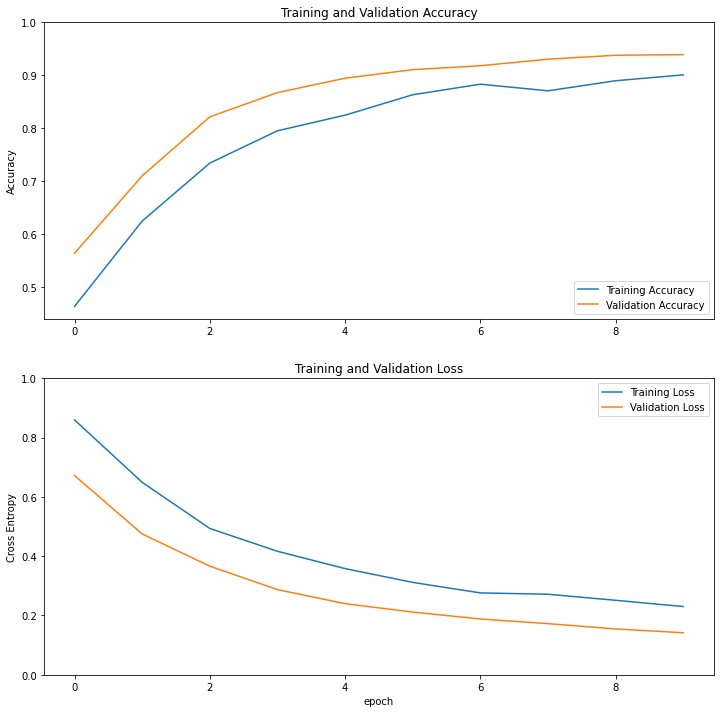

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


Now we have a model that works for our usecase.

Next, we will unfreeze the model, and train it again on the new data. This process is called "fine-tuning".

In [22]:
base_model.trainable = True


In [23]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False


Number of layers in the base model:  154


In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.RMSprop(
                  learning_rate=base_learning_rate/10),
              metrics=['accuracy'])


In [25]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [26]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         workers=4)


Epoch 10/20
63/63 [==============================] - 9s 81ms/step - loss: 0.1522 - accuracy: 0.9345 - val_loss: 0.0566 - val_accuracy: 0.9740
Epoch 11/20
63/63 [==============================] - 4s 68ms/step - loss: 0.1230 - accuracy: 0.9510 - val_loss: 0.0502 - val_accuracy: 0.9752
Epoch 12/20
63/63 [==============================] - 4s 67ms/step - loss: 0.1128 - accuracy: 0.9515 - val_loss: 0.0444 - val_accuracy: 0.9777
Epoch 13/20
63/63 [==============================] - 4s 68ms/step - loss: 0.1087 - accuracy: 0.9560 - val_loss: 0.0530 - val_accuracy: 0.9740
Epoch 14/20
63/63 [==============================] - 4s 69ms/step - loss: 0.0894 - accuracy: 0.9595 - val_loss: 0.0310 - val_accuracy: 0.9827
Epoch 15/20
63/63 [==============================] - 4s 65ms/step - loss: 0.0850 - accuracy: 0.9640 - val_loss: 0.0329 - val_accuracy: 0.9839
Epoch 16/20
63/63 [==============================] - 4s 67ms/step - loss: 0.0836 - accuracy: 0.9650 - val_loss: 0.0322 - val_accuracy: 0.9876
Epoch 

In [27]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


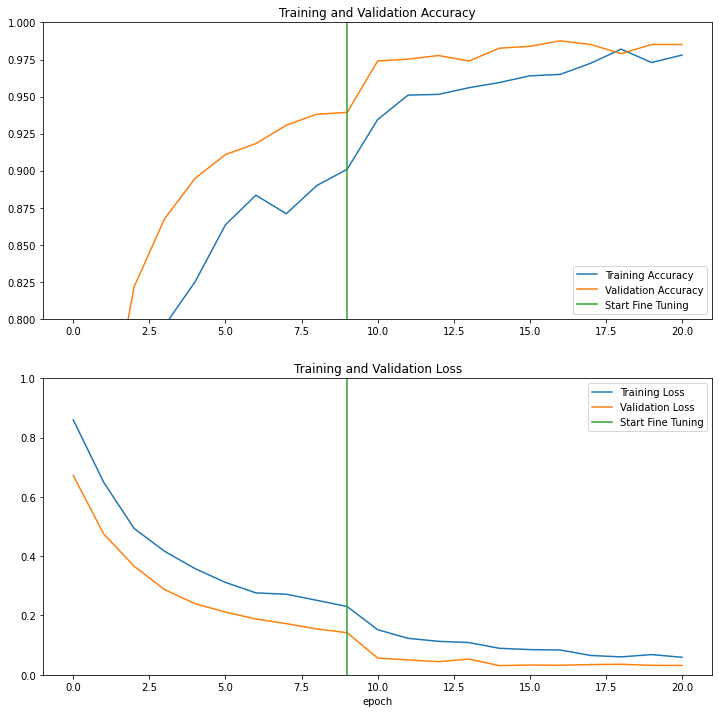

In [28]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)


6/6 [==============================] - 0s 28ms/step - loss: 0.0175 - accuracy: 0.9896
Test accuracy : 0.9895833134651184


## Done!